In [15]:
import random, time, os, sys
from tqdm.notebook import tqdm_notebook
from collections.abc import Iterable
from typing import List, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, LambdaLR, ReduceLROnPlateau

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
rmse = lambda y, yHat: np.sqrt(mse(yHat, y))

NVIDIA GeForce RTX 3090 Ti


In [16]:

rawFilePath = "./data/data.csv"
sampleFilePath = "./data/sample_100k.csv"

colRaw = ["latitude","longitude","value","radiation","aqi","co","dew",
        "so2","no2","o3","city","radiation2","value2","height","surface",]
col = ["latitude", "longitude", "value", "aqi","so2", "no2", "o3", "value2"]
colType = {"latitude":np.float64, "longitude":np.float64, "value":np.float64, 
        "aqi":np.float64,"so2":np.float64, "no2":np.float64, "o3":np.float64, 
        "value2":np.float64}

rawCnt = 12919142 # obtained from file
sampleCnt = 1291914

''' Initial Sampling, run once '''
if True:
    skipIndex = lambda n, k: sorted(random.sample(range(1,n+1),n-k)) # random select skipping rows
    df = pd.read_csv(rawFilePath, skiprows=skipIndex(rawCnt, sampleCnt), 
        encoding='utf-8', header=None, names=colRaw, dtype=colType, na_values=['-'])
    dfCleaned = df[col].dropna() # remove 
    dfCleaned.to_csv(sampleFilePath, encoding='utf-8',index=False)

C:\Users\shane\AppData\Local\Temp\ipykernel_25572\4058859537.py:17: DtypeWarning: Columns (3,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(rawFilePath, skiprows=skipIndex(rawCnt, sampleCnt),


In [17]:
class AirQualityDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.target = "aqi"

        self.X = self.df.drop(self.target, axis=1) 
        self.y = self.df[self.target]

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X.iloc[idx].values, self.y[idx]]


def normalize(df, means=None, stds=None):
    ''' normalized data for learning '''
    doInit =(means == None)
    if doInit:
        means, stds = {},{}
    for n in df.columns:
        if doInit:
            means[n],stds[n] = df[n].mean(), df[n].std()
        df[n] = (df[n]-means[n]) / (1e-7 + stds[n])
    return means, stds


def normReverted(df:pd.DataFrame, means:Dict, stds:Dict):
    for n in df.columns:
        df[n] = df[n] * (1e-7 + stds[n]) + means[n]
    return df


In [18]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x.squeeze()

    def resetWeights(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()



In [19]:
# help functions




def myLayer(n_in:int, n_out:int, bn:bool=True, p:float=0., activLayer=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `activLayer`."
    layers = []
    if bn: 
        layers.append(nn.BatchNorm1d(n_in))
    if p != 0: 
        layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if activLayer is not None: 
        layers.append(activLayer)
    return layers
       

class Net2(nn.Module):
    "Basic model for tabular data."
    def __init__(self, catDims:List[int], cntNum:int, out_sz:int, layers:List[int], 
                dropPcts:List[float], embDropPct:float=0., y_range=List[float], 
                use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        self.catDims = catDims
        self.cntNum = cntNum
        self.y_range = y_range

        # check dropout pct list is good
        if (type(dropPcts) is not list) or (len(dropPcts) != len(layers)):
            raise ValueError(f"Dropout size incorrect: is {len(dropPcts)} should be {len(layers)}")
        
        # create categorical embeddings
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in self.catDims]) # embedding layers for categoricals as list
        self.cntEmb = sum(e.embedding_dim for e in self.embeds) # cntEmb = 0 if no categorical data
        self.embDropPct = nn.Dropout(embDropPct)
        
        # numerical batchnorm
        self.bcntNum = nn.BatchNorm1d(self.cntNum)
        
        # Count total
        
        layerSizes = [self.cntEmb + self.cntNum] + layers + [out_sz] 
        activLayers = [nn.ReLU(inplace=True) for _ in range(len(layerSizes)-2)] + [None]

        # Chaining Layers
        layers = []
        degIns, degOuts = layerSizes[:-1], layerSizes[1:]
        dropPcts = [0.] + dropPcts # no dropout for first layer
        for i,(degIn, degOut, dropPct, activ) in enumerate(zip(degIns, degOuts, dropPcts, activLayers)):
            layers += myLayer(degIn, degOut, bn=use_bn and i!=0, p=dropPct, activLayer=activ)
        if bn_final: 
            layers.append(nn.BatchNorm1d(layerSizes[-1]))

        self.layers = nn.Sequential(*layers)


    def forward(self, xCont, xCat=None):
        if self.catDims != [] and xCat != None: # have categorical columns
            x = [e(xCat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.embDropPct(x) # pass it through a dropout layer
        if self.cntNum != 0:
            xCont = self.bcntNum(xCont) # batchnorm1d
            x = torch.cat([x, xCont], 1) if self.catDims != [] else xCont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()
    
    def resetWeights(self):
        for layer in self.layers:
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()
    

In [20]:
network = Net2(catDims=[], cntNum=len(col)-1, out_sz=1, layers=[64, 32, 16, 8],
        dropPcts=[0.025, 0.05, 0.1, 0.2], y_range=[0.0, 1.0]).to(device)
network

Net2(
  (embeds): ModuleList()
  (embDropPct): Dropout(p=0.0, inplace=False)
  (bcntNum): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.025, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, tra

In [21]:
def fit(model, trainDl, valDl, lossFn, optimizer, scheduler, epochs):
    lr = []
    lossTrain, accTrain = [], []
    lossVal, accVal = [], []
    
    pbarIter = tqdm_notebook(iter(range(epochs)), leave=False, total=epochs)
    for epoch in pbarIter:
        pbarIter.set_description(f"Epoch {epoch}")
        yTrainAll, yHatTrainAll = [], []
        yValAll, yHatValAll = [], []
        lossTrainSum = 0.0
        lossValSum = 0.0


        ''' Train '''
        for X, y in trainDl:
            # Init
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            # Predict
            yHat = model(X.float())
            loss = lossFn(yHat, y.float())
            # Stats
            lr.append(optimizer.param_groups[0]['lr'])
            yTrainAll += list(y.cpu().data.numpy())
            yHatTrainAll += list(yHat.cpu().data.numpy())
            lossTrainSum += loss.item()
            # backprop
            loss.backward()
            optimizer.step()
            if(scheduler != None): scheduler.step()

        # Epoch stats
        lossTrain.append(lossTrainSum / len(trainDl))
        accTrain.append(rmse(yTrainAll, yHatTrainAll))
        pbarIter.set_postfix(loss=np.sqrt(lossTrain[-1]))


        ''' Validation '''
        torch.set_grad_enabled(False)
        for X, y in valDl:
            # Init
            X = X.to(device)
            y = y.to(device)
            # Predict
            yHat = model(X.float())
            loss = lossFn(yHat, y.float())
            # stats
            yValAll += list(y.cpu().data.numpy())
            yHatValAll += list(yHat.cpu().data.numpy())
            lossValSum += loss.item()
        torch.set_grad_enabled(True)
        # Epoch stats
        lossVal.append(lossValSum / len(valDl))
        accVal.append(rmse(yValAll, yHatValAll))
        
    return lossTrain, accTrain, lossVal, accVal, lr

In [22]:
# Testing
def test(model, testDl, lossFn): # model, trainDl, valDl, lossFn, optimizer, epochs
    yTestAll, yHatTestAll = [], []
    lossTestSum = 0.0
    
    for i, (X, y) in enumerate(testDl):
        # Init
        X = X.to(device)
        y = y.to(device)
        # Predict
        yHat = model(X.float())
        loss = lossFn(yHat, y.float())
        # stats
        yTestAll += list(y.cpu().data.numpy())
        yHatTestAll += list(yHat.cpu().data.numpy())
        lossTestSum += loss.item()
    # stats
    loss = lossTestSum / (i + 1)
    acc = rmse(yTestAll, yHatTestAll)
    return loss, acc

In [23]:
def saveModel(network, saveAt:str):
    torch.save(network, saveAt)

def loadModel(loadFrom:str):
    return torch.load(loadFrom)

In [24]:
# Plotting Related Stuff
class ListAverager:
    def __init__(self):
        self.ls = []
        self.cnt = 0
    
    def append(self, l):
        self.ls.append(l)
        self.cnt += 1
    
    def avg(self):
        lsNp = np.array(self.ls)
        return np.mean(lsNp, axis=0)


def plotSingle(l, label):
    plt.plot(np.arange(len(l)), l, label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
def plotList(ll, labels):
    colors = ["b", "r", "b", "r"]
    linestyles = ["dashdot", "dashdot", "solid", "solid"]
    for ls, label, color, linestyle in zip(ll, labels, colors, linestyles):
        plt.plot(np.arange(len(ls)), ls, color=color, linestyle = linestyle, label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [25]:
def logResult(network):
    ''' For network debugging '''
    with open('./debugText.txt', 'w+') as f:
        oldOut = sys.stdout
        sys.stdout = f
        print('-----Linear Layer 1 Weight:---')
        print(network.layers[0].weight)
        print('-----Linear Layer 2 Weight:---')
        print(network.layers[4].weight)
        print('-----Linear Layer 3 Weight:---')
        print(network.layers[8].weight)
        print('-----Linear Layer 4 Weight:---')
        print(network.layers[12].weight)
        sys.stdout = oldOut

In [26]:
def train(trainDataPath, modelPath = "./model/model.pth"):
    # Setup Model
    doTest = True
    plotResult = True
    kFolds = 5
    numEpochs = 100
    batchSize = 128
    learningRate = 1e-3
    weightDecay = 1e-3
    lossFunction = nn.MSELoss()
    
    # Load Data
    df = pd.read_csv(trainDataPath, encoding='utf-8')
    means, stds = normalize(df)
    dataset = AirQualityDataset(df)
    
    if doTest: # to split or not to split
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        trainSet, testSet = random_split(dataset, [train_size, test_size])
    else:
        trainSet = dataset

    # Start Training
    kfold = KFold(n_splits=kFolds, shuffle=True)
    lossTrains, accTrains, lossVals, accVals, lrs = [ListAverager() for _ in range(5)]
    for fold, (trainIdx, valIdx) in enumerate(kfold.split(trainSet)):
        print(f"--- Fold {fold} ---")
        trainSubsampler = SubsetRandomSampler(trainIdx)
        valSubsampler = SubsetRandomSampler(valIdx)
        trainLoader = DataLoader(trainSet, batch_size=batchSize, sampler=trainSubsampler)
        valLoader = DataLoader(trainSet, batch_size=batchSize, sampler=valSubsampler)

        # degIn = len(col)-1
        # degFeat = 10
        # network = Net(degIn, degFeat).to(device)
        network = Net2(catDims=[], cntNum=len(col)-1, out_sz=1, layers=[64, 32, 16, 8],
                dropPcts=[0.025, 0.05, 0.1, 0.2], y_range=[0.0, 1.0]).to(device)
        network.dataMeans = nn.ParameterDict(means) # for data restore
        network.dataStds = nn.ParameterDict(stds) # for data restore
        network.resetWeights()
        # optimizer = torch.optim.SGD(network.parameters(), lr=learningRate, momentum=momentum)
        optimizer = optim.Adam(network.parameters(), lr=learningRate, weight_decay=weightDecay)
        # scheduler = CosineAnnealingLR(optimizer, T_max=9e4, eta_min=1e-5)  # T_max: width of cosine/
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[20000,60000,120000], gamma=0.1)
        
        # scheduler = ReduceLROnPlateau(optimizer, 'min')
        # scheduler = ExponentialLR(optimizer, gamma=0.9)
        # scheduler = None
        
        lossTrain, accTrain, lossVal, accVal, lr = fit(network, 
                    trainLoader, valLoader, lossFunction, optimizer, scheduler, numEpochs)
        lossTrains.append(lossTrain)
        accTrains.append(accTrain)
        lossVals.append(lossVal)
        accVals.append(accVal)
        lrs.append(lr)
        break
    lossTrain = np.sqrt(lossTrains.avg()) # use rmse
    accTrain = accTrains.avg()
    lossVal = np.sqrt(lossVals.avg()) # use rmse
    accVal = accVals.avg()
    lr = lrs.avg()
    if plotResult:
        plotList([lossTrain, lossVal, accTrain, accVal], ["Loss Train", "Loss Val", "Acc Train", "Acc Val"])
        plotSingle(lr, "Learning Rate")
    saveModel(network, modelPath)

    if doTest:
        testLoader = DataLoader(testSet, batch_size=batchSize, shuffle=True)
        loss, acc = test(network, testLoader, lossFunction)
        print(f"Test loss: {np.sqrt(loss)}, acc: {acc}")
    logResult(network) # lossTrain, accTrain, lossVal, accVal, lr) # for network inspection



In [27]:
def predict(dataPath, modelPath = "./model/model.pth"):
    df = pd.read_csv(dataPath, encoding='utf-8')
    network = loadModel(modelPath)
    means, stds = network.dataMeans, network.dataStds
    normalize(df, means, stds)
    
    yHat = network(torch.tensor(df.values).float().cuda())
    yHat = yHat.cpu().detach().numpy()
    yPred = yHat * (1e-7 + stds["aqi"]) + means["aqi"]
    return yPred

--- Fold 0 ---


  0%|          | 0/100 [00:00<?, ?it/s]

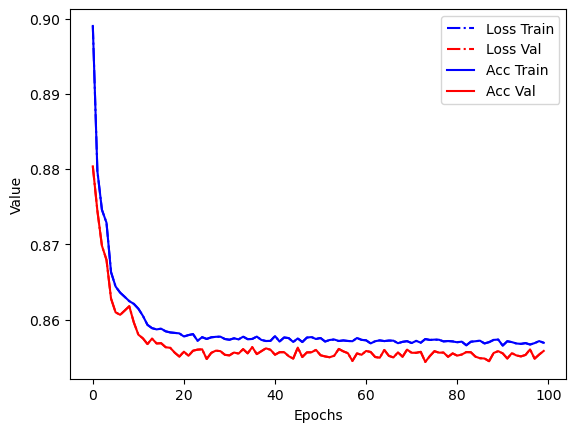

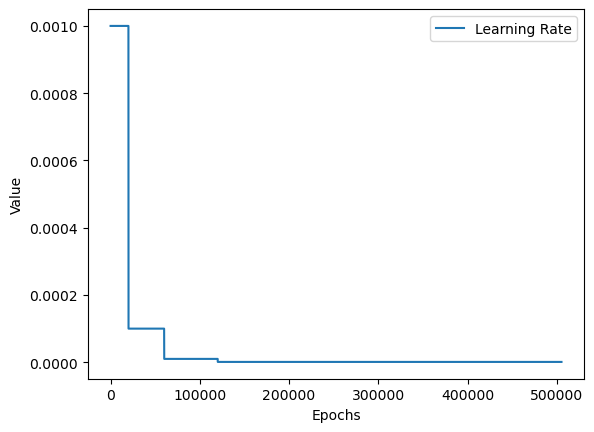

Test loss: 0.8567235883870755, acc: 0.8566963422920795
[27.638151 26.672995 28.291586 26.689184 26.709013 26.67717  26.671497
 26.675175 26.67434  26.67429  26.671787 26.68009  26.67195  26.671618
 26.697962 26.671959 44.248535 36.965862 26.903564 41.599575 26.710064
 42.288948 38.56675  44.175896 26.677963 43.98416  43.98763  28.249168
 28.068977 26.747528 26.815933]


In [28]:
train(sampleFilePath)
result = predict("./data/test.csv")
print(result)